# Random Forest

In [1]:
import some_load_train_evaluate_functions as ml

from sklearn.ensemble import RandomForestClassifier

In [2]:
path = '../KG/db.env'

driver = ml.connect_to_neo4j(path)

Connected to database successfully.


### Load Data

In [3]:
# Diabetes data

diabetes_df = ml.get_data_of_disease(driver, 'Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


### Training

In [4]:
random_forest = RandomForestClassifier(random_state=42)

# Attributes and Labels

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

# Training

random_forest.fit(X_train, y_train)

# Accuracy scores

y_pred = random_forest.predict(X_val)

print('Training Accuracy: ',ml.accuracy_score(y_train, random_forest.predict(X_train)))

print('Testing Accuracy: ',ml.accuracy_score(y_val, y_pred))

Training Accuracy:  0.9955018273826258
Testing Accuracy:  0.9960640989597975


## Feature Selection

### Correlation Analysis

In [8]:
random_forest_test = RandomForestClassifier(random_state=42, n_jobs=-1)

In [6]:
pos_corr, neg_corr = ml.get_correlated_features(diabetes_df,'Diabetes',pos=0.1,neg=-0.1)

corr_features = ['Gender'] + list(pos_corr.keys()[1:10]) + list(neg_corr.keys()[:10])
corr_features

['Gender',
 'Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Triglyceride [mmol/L]',
 'Total Lycopene [umol/L]',
 'Trans-lycopene [umol/L]',
 'Platelet count [1000 cells/uL]',
 'A/G Ratio',
 'Chloride [mmol/L]',
 'Platelet_WBC Ratio',
 'Direct HDL-Cholesterol [mmol/L]',
 'Albumin [g/dL]',
 'Alpha-crypotoxanthin [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio']

In [7]:
ml.evaluate_feature_set(corr_features, random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 0.996

Recall: 0.975

F1-Score: 0.985


### SelectFromModel

In [8]:
sfm_features = ml.select_from_model_features(random_forest_test,X,y)
sfm_features

['Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Chromium [nmol/L]',
 'Cobalt [nmol/L]',
 'Fasting Glucose [mmol/L]',
 'Glycohemoglobin [%]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]']

In [9]:
sfm_features = list(sfm_features)

ml.evaluate_feature_set(sfm_features, random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### SelectKBest

In [10]:
k_best_features = ml.select_k_best(X, y, n=30)
k_best_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Retinol [umol/L]',
 'Lymphocyte [%]',
 'Insulin [pmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Segmented neutrophils [%]',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-crypotoxanthin [umol/L]',
 'Albumin [g/dL]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Platelet_WBC Ratio',
 'C-Reactive Protein [mg/L]',
 'Creatinine [mg/dL]',
 'Ferritin [ng/mL]',
 'Chloride [mmol/L]',
 'Red cell distribution width [%]',
 'Triglyceride [mmol/L]',
 'A/G Ratio',
 'Platelet count [1000 cells/uL]',
 'Triglyceride_HDL Ratio',
 'Trans-lycopene [umol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Total Lycopene [umol/L]',
 'Mean platelet volume [fL]']

In [11]:
ml.evaluate_feature_set(k_best_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Recursive Feature Elimination (RFE) 

In [12]:
rfe_features = ml.select_rfe_features(random_forest_test,X,y,n=30,step=0.5)
rfe_features[:30]

['Total Cholesterol [mmol/L]',
 'Ferritin [ng/mL]',
 'Creatinine [mg/dL]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Fasting Glucose [mmol/L]',
 'Gamma-tocopherol [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Cobalt [nmol/L]',
 'Glycohemoglobin [%]',
 'C-Reactive Protein [mg/L]',
 'Osmolality [mmol/Kg]',
 'Iron frozen [umol/L]',
 'Non_HDL Ratio',
 'Lymphocyte [%]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Chloride [mmol/L]',
 'Vitamin C [umol/L]',
 'Platelet count [1000 cells/uL]',
 'Retinol [umol/L]',
 'Insulin [pmol/L]',
 'Age',
 'BMI',
 'Blood Urea Nitrogen [mg/dL]',
 'Beta-cryptoxanthin [umol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Chromium [nmol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Trans-beta-carotene [umol/L]',
 'A/G Ratio',
 'Total Lycopene [umol/L]']

In [13]:
ml.evaluate_feature_set(rfe_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Lasso Regularization

In [16]:
l1_selected_features = ml.log_reg_lasso_select(X_train, y_train)
l1_selected_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'Gender',
 'BMI',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Alkaline Phosphatase [IU/L]',
 'Insulin [pmol/L]',
 'Osmolality [mmol/Kg]',
 'Vitamin C [umol/L]',
 'Blood lead [umol/L]',
 'Transferrin receptor [nmol/L]',
 'Gamma Glutamyl Transferase [IU/L]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Aspartate Aminotransferase [U/L]',
 'Transferrin Saturation [%]',
 'Creatine Phosphokinase [IU/L]',
 'LDL-Cholesterol(NIH2) [mmol/L]',
 'Lactate Dehydrogenase [IU/L]',
 'Creatinine [mg/dL]',
 'Total Cholestrol_HDL Ratio',
 'White blood cell count [1000 cells/uL]',
 'Platelet_Lymphocyte Ratio',
 'Retinyl palmitate [umol/L]',
 'Uric Acid [mg/dL]',
 'Bicarbonate [mmol/L]',
 'Sodium [mmol/L]',
 'Blood selenium [umol/L]']

In [17]:
ml.evaluate_feature_set(l1_selected_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 0.996

Recall: 0.975

F1-Score: 0.985


### Relief F

In [18]:
relieff_features = ml.relief_feature_select(30,X,y)

In [19]:
relieff_features[:30]

['Age',
 'Glycohemoglobin [%]',
 'BMI',
 'Segmented neutrophils [%]',
 'Hematocrit [%]',
 'Lymphocyte [%]',
 'Hemoglobin [g/dL]',
 'Fasting Glucose [mmol/L]',
 'Retinol [umol/L]',
 'Total Cholesterol [mmol/L]',
 'Non_HDL Ratio',
 'Neutrophil_Lymphocyte Ratio',
 'Alpha-tocopherol [umol/L]',
 'Osmolality [mmol/Kg]',
 'Mean cell volume [fL]',
 'Sodium [mmol/L]',
 'Total Cholestrol_HDL Ratio',
 'Total Iron Binding Capacity [umol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Chloride [mmol/L]',
 'Mean cell hemoglobin [pg]',
 'RBC count [million cells/uL]',
 'Total Protein [g/dL]',
 'Total Calcium [mg/dL]',
 'A/G Ratio',
 'Potassium [mmol/L]',
 'Uric Acid [mg/dL]',
 'Lactate Dehydrogenase [IU/L]',
 'Transferrin Saturation [%]',
 'Mean platelet volume [fL]']

In [23]:
ml.evaluate_feature_set(relieff_features[:30], random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Random Forest Feature Importances

In [5]:
def get_rand_forest_features(model, X_train):
    random_forest_features = ml.pd.DataFrame(model.feature_importances_, index=X_train.columns,
                                             columns=['Importance'])
    random_forest_features = random_forest_features.sort_values('Importance', ascending=False)
    random_forest_features = list(random_forest_features.index)
    
    return random_forest_features

In [6]:
random_forest_features = get_rand_forest_features(random_forest, X_train)
random_forest_features[:30]

['Glycohemoglobin [%]',
 'Fasting Glucose [mmol/L]',
 'Age',
 'BMI',
 'Chromium [nmol/L]',
 'Cobalt [nmol/L]',
 'Blood Urea Nitrogen [mg/dL]',
 'Osmolality [mmol/Kg]',
 'Total Cholesterol [mmol/L]',
 'Retinol [umol/L]',
 'Lymphocyte_C-Reactive Protein Ratio',
 'Creatinine [mg/dL]',
 'Insulin [pmol/L]',
 'Beta-cryptoxanthin [umol/L]',
 'Non_HDL Ratio',
 'Chloride [mmol/L]',
 'Alpha-tocopherol [umol/L]',
 'Alpha-crypotoxanthin [umol/L]',
 'Triglyceride_HDL Ratio',
 'Trans-beta-carotene [umol/L]',
 'Transferrin receptor [nmol/L]',
 '25-hydroxyvitamin D2 + D3 [nmol/L]',
 'Lymphocyte_Monocyte Ratio',
 'Gamma-tocopherol [umol/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Creatine Phosphokinase [IU/L]',
 'C-Reactive Protein [mg/L]',
 'Triglyceride [mmol/L]',
 'RBC count [million cells/uL]',
 'Ferritin [ng/mL]']

In [9]:
ml.evaluate_feature_set(random_forest_features, random_forest_test, X_train, y_train, X_val, y_val)


Train Accuracy: 0.996

Test Accuracy: 0.996

Precision: 0.996

Recall: 0.973

F1-Score: 0.984


### Optimal no. of features

In [10]:
final_features = list(random_forest_features) 


Maximum accuracy = 0.9394 for 69 features


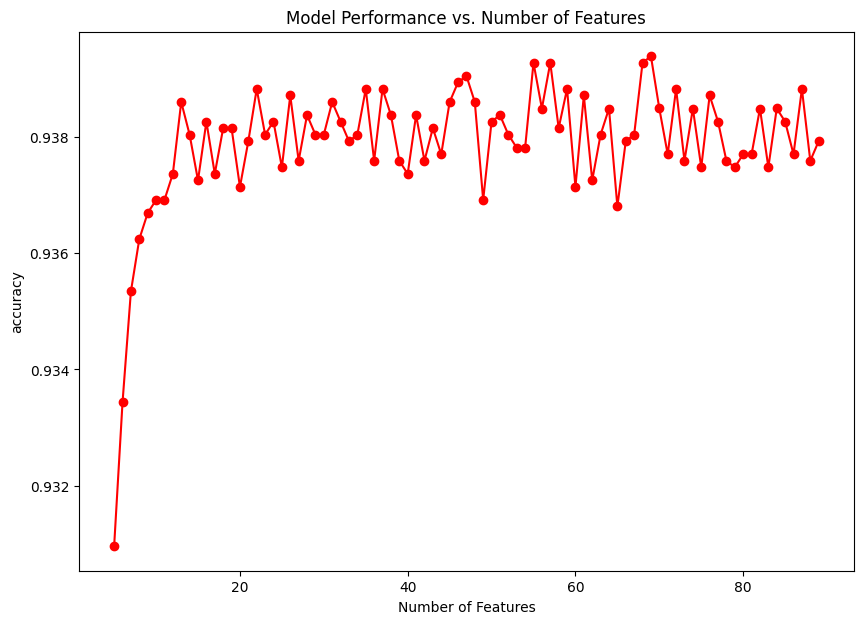

In [28]:
# Optimal no. of features

ml.plot_num_feature_performance(random_forest_test,  X, y, final_features, scoring='accuracy')


Maximum f1 = 0.7368 for 37 features


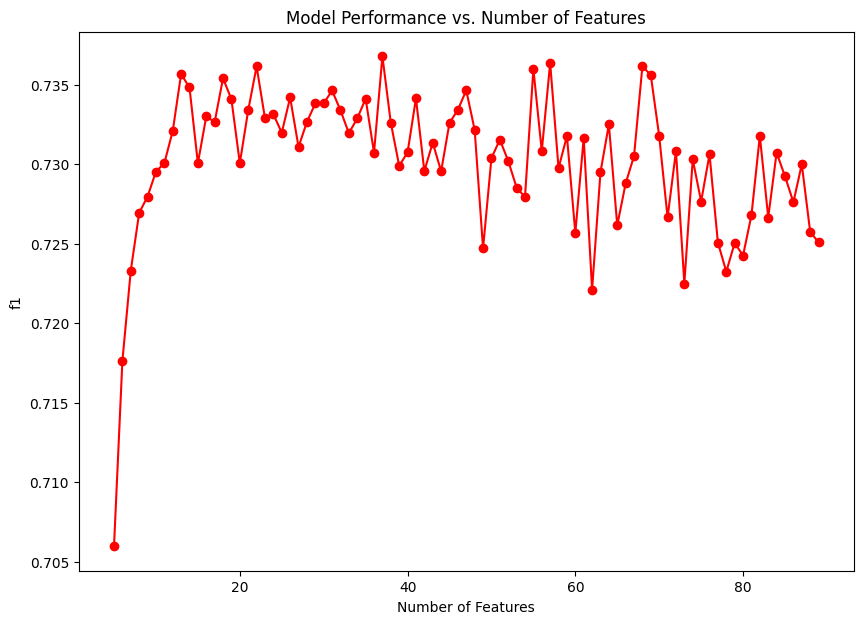

In [29]:
# Optimal no. of features

ml.plot_num_feature_performance(random_forest_test,  X, y, final_features, scoring='f1')


Maximum recall = 0.6550 for 18 features


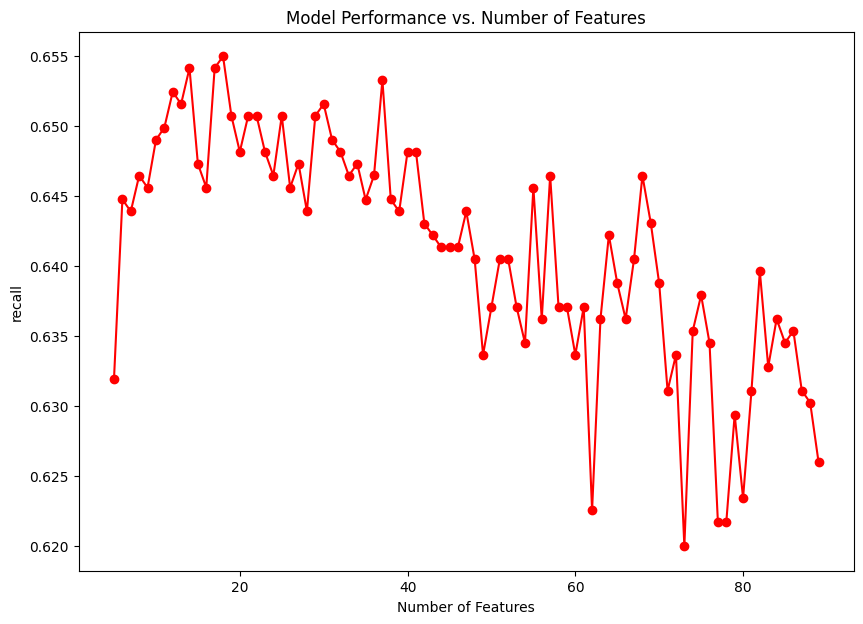

In [30]:
# Optimal no. of features

ml.plot_num_feature_performance(random_forest_test,  X, y, final_features, scoring='recall')

In [11]:
num_features = 37

selected = final_features[:num_features]
selected.append('Diabetes')

diabetes_df = diabetes_df[selected]

In [12]:
# Save feature set
    
with open('../Models/Diabetes/Feature Sets/Random Forest Features.pkl', 'wb') as f:
    ml.pickle.dump(selected, f)

## Preprocessing

### No Imputation

In [54]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                        impute = False, scale=True,
                                                        imputer=None,
                                                        random_state=42)

In [55]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.973

Test Accuracy: 0.973

Precision: 1.000

Recall: 0.800

F1-Score: 0.889


### Zero Imputation

In [32]:
# Imputing null values with zeroes

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                        impute = True, scale=True,
                                                        imputer=ml.SimpleImputer(strategy='constant',fill_value=0),
                                                        random_state=42)

In [33]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Mode Imputation

In [34]:
# Imputing with most frequent values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)

In [35]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### k-NN Imputation

In [36]:
# Imputing missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.KNNImputer(n_neighbors=20),
                                                              random_state=42)

In [37]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.987

Recall: 0.975

F1-Score: 0.981


### Multiple Imputation by Chained Equations (MICE)

In [60]:
# Imputes by looking at data from other columns and trying to estimate the best prediction for each missing value.

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.IterativeImputer(max_iter=20),
                                                              random_state=42)

In [61]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.987

Recall: 0.975

F1-Score: 0.981


### Mean Imputation

In [42]:
# Splitting and Preprocessing data

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [43]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Dropping Null Values

In [44]:
# Drop null values
diabetes_df_na = diabetes_df.dropna()

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df_na, label = 'Diabetes',
                                                              impute = False, scale=True,
                                                              random_state=42)

In [45]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)

# Over fitting


Train Accuracy: 1.000

Test Accuracy: 1.000

Precision: 1.000

Recall: 1.000

F1-Score: 1.000


### Median Imputation

In [63]:
# Imputing with median values

X, y, X_train, X_val, X_test, y_train, y_val, y_test = ml.preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=ml.SimpleImputer(strategy='median'),
                                                              random_state=42)

In [64]:
random_forest.fit(X_train, y_train)

ml.evaluate_model_metrics(random_forest,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


## Oversampling and Undersampling

### Random Oversampling

In [65]:
X_ros, y_ros = ml.random_over_sample(X_train, y_train)

random_forest.fit(X_ros, y_ros)

ml.evaluate_model_metrics(random_forest,X_ros, y_ros,X_val, y_val)


Train Accuracy: 0.993

Test Accuracy: 0.988

Precision: 0.924

Recall: 0.998

F1-Score: 0.959


### SMOTE (Synthetic Minority Over-sampling Technique)

In [66]:
X_smote, y_smote = ml.smote_over_sample(X_train, y_train)

random_forest.fit(X_smote, y_smote)

ml.evaluate_model_metrics(random_forest,X_smote, y_smote,X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.991

Precision: 0.945

Recall: 0.990

F1-Score: 0.967


### Random Undersampling

In [67]:
X_rus, y_rus = ml.random_under_sample(X_train, y_train)

random_forest.fit(X_rus, y_rus)

ml.evaluate_model_metrics(random_forest,X_rus, y_rus,X_val, y_val)


Train Accuracy: 0.994

Test Accuracy: 0.907

Precision: 0.595

Recall: 0.994

F1-Score: 0.744


### Tomek Links

In [68]:
X_tomek, y_tomek = ml.tomek_links(X_train, y_train)

random_forest.fit(X_tomek, y_tomek)

ml.evaluate_model_metrics(random_forest,X_tomek, y_tomek,X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.992

Precision: 0.963

Recall: 0.975

F1-Score: 0.969


### SMOTE + Tomek Links

In [69]:
X_smote_tomek, y_smote_tomek = ml.smote_tomek(X_train, y_train)

random_forest.fit(X_smote_tomek, y_smote_tomek)

ml.evaluate_model_metrics(random_forest,X_smote_tomek, y_smote_tomek,X_val, y_val)


Train Accuracy: 0.995

Test Accuracy: 0.988

Precision: 0.932

Recall: 0.988

F1-Score: 0.959


In [70]:
# Model seems to perform better without oversampling or undersampling

## Hyperparameter Optimization 

### Grid Search

In [71]:
param_grid = {
    
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_jobs': [-1],
    'random_state': [42]

}

In [72]:
grid_best_params, random_forest_grid = ml.grid_search_optimize(random_forest, param_grid, X_train, 
                                                                y_train, cv=10,scoring='accuracy')

In [73]:
grid_best_params

{'bootstrap': True,
 'criterion': 'entropy',
 'max_features': 'log2',
 'n_jobs': -1,
 'random_state': 42}

In [74]:
ml.evaluate_model_metrics(random_forest_grid,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Random Search

In [75]:
rand_best_params, random_forest_rand = ml.random_search_optimize(random_forest,param_grid,n_iter=100,cv=5,
                                                               X_train=X_train, y_train=y_train,
                                                               scoring='accuracy')

In [76]:
rand_best_params

{'random_state': 42,
 'n_jobs': -1,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'bootstrap': True}

In [77]:
ml.evaluate_model_metrics(random_forest_rand,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.989

Recall: 0.971

F1-Score: 0.980


### Optuna

In [82]:
def objective(trial):

    params = {
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1])
    }
     
    model = RandomForestClassifier(**params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = ml.accuracy_score(y_test, y_pred)

    return accuracy

In [83]:
best_trial , random_forest_opt = ml.optuna_optimize(objective, RandomForestClassifier, n_trials=150)

In [84]:
best_trial

{'bootstrap': False, 'criterion': 'entropy', 'n_jobs': -1}

In [86]:
random_forest_opt.fit(X_train,y_train)

ml.evaluate_model_metrics(random_forest_opt,X_train,y_train,X_val,y_val)


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.996

Recall: 0.965

F1-Score: 0.980


## Evaluation on Test Set


Train Accuracy: 0.995

Test Accuracy: 0.995

Precision: 0.991

Recall: 0.970

F1-Score: 0.981

Confusion Matrix:

[[3082    4]
 [  14  457]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      3086
     Class 1       0.99      0.97      0.98       471

    accuracy                           0.99      3557
   macro avg       0.99      0.98      0.99      3557
weighted avg       0.99      0.99      0.99      3557


ROC-AUC Curve:


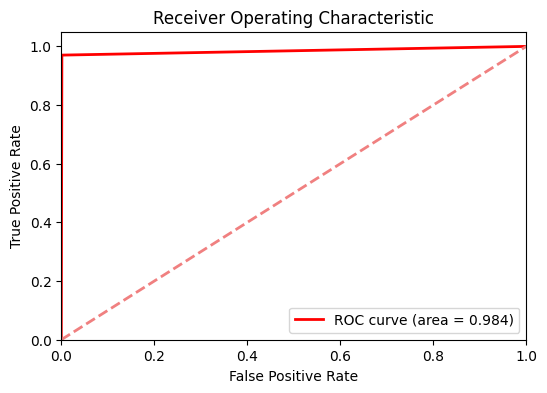

In [87]:
# After evaluating on the validation set, we evaluate and finalize on the test set

ml.evaluate_model_metrics(random_forest_grid, X_train, y_train, X_test, y_test, verbose=6)

## Cross Validation

### K-fold

In [88]:
ml.k_cross_validate(random_forest,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94044944 0.92921348 0.94382022 0.93250844 0.92463442 0.93588301
 0.94825647 0.94938133 0.93475816 0.94263217]

Mean accuracy score:  0.938153713931826

Standard deviation:  0.00772538207107954


In [89]:
ml.k_cross_validate(random_forest_grid,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.93483146 0.93146067 0.94269663 0.928009   0.93025872 0.9336333
 0.94713161 0.94713161 0.92688414 0.9336333 ]

Mean accuracy score:  0.9355670428836845

Standard deviation:  0.007098497145512116


In [90]:
ml.k_cross_validate(random_forest_rand,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94044944 0.92921348 0.94382022 0.93250844 0.92463442 0.93588301
 0.94825647 0.94938133 0.93475816 0.94263217]

Mean accuracy score:  0.938153713931826

Standard deviation:  0.00772538207107954


In [91]:
ml.k_cross_validate(random_forest_opt,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.93820225 0.93483146 0.94494382 0.93250844 0.93138358 0.93250844
 0.94825647 0.95163105 0.93250844 0.93588301]

Mean accuracy score:  0.9382656943163002

Standard deviation:  0.0069808473229533196


### Stratified K-fold

In [92]:
ml.stratified_k_cross_validate(random_forest,X,y,n_splits=10)


Average Accuracy: 0.9377055396165366

Average Precision: 0.8439532806648413

Average Recall: 0.6481167608286252

Average F1-Score: 0.731703007089086


In [93]:
ml.stratified_k_cross_validate(random_forest_grid,X,y,n_splits=10)


Average Accuracy: 0.9387167755715928

Average Precision: 0.8647021715571388

Average Recall: 0.6353179776908591

Average F1-Score: 0.731035166226115


In [94]:
ml.stratified_k_cross_validate(random_forest_rand,X,y,n_splits=10)


Average Accuracy: 0.9377055396165366

Average Precision: 0.8439532806648413

Average Recall: 0.6481167608286252

Average F1-Score: 0.731703007089086


In [95]:
ml.stratified_k_cross_validate(random_forest_opt,X,y,n_splits=10)


Average Accuracy: 0.9375929272885835

Average Precision: 0.8492054489475264

Average Recall: 0.6404316963638997

Average F1-Score: 0.7291493873396249


### Save Model

In [96]:
final_random_forest_estimator = random_forest

In [98]:
# Saving the model

ml.save_model(final_random_forest_estimator, "../Models/Diabetes/Random_Forest_Classifier.pkl")

Overwrite File? [y/n]: y
Saved Model


## Prediction

In [99]:
# Predicting on perturbed values

ml.predict_on_modified_instance(final_random_forest_estimator, X_test.iloc[0], y_test.iloc[0], 0.4)

Instance:
 [ 0.36277812  0.37087129  1.68064713  0.02724686 -0.11940531 -0.31069446
  1.73922308 -0.1887287  -0.28236053  0.20292565 -0.61358571  0.52721304
 -0.34667362 -0.71396502  0.074086   -1.32780587 -0.0776065  -1.20619448
  0.10531821 -0.1658756   0.06441522  0.43590044 -0.58557353 -1.41738231
 -0.90948626 -0.015076    1.64528543 -0.1281434  -0.41053261  0.92948182
 -0.09328857  0.1836789   0.01779198 -0.50748011  0.73677237 -0.36046577
 -1.01267186]

Expected Class:  0

 Modified Instance:
 [ 0.36277812  0.24817629  1.58127961  0.14590851 -0.06904653 -0.23497043
  1.80829245 -0.40251932 -0.26256647  0.43095256 -0.66040698  0.39721295
 -0.17124015 -0.6796505   0.19601173 -1.37797468 -0.21907154 -1.14412193
  0.33367967 -0.19786089  0.10415802  0.45764952 -0.45499501 -1.58103725
 -0.88414969  0.07088629  1.780132   -0.12122097 -0.74789161  0.82053275
 -0.13810461  0.06493808 -0.15543058 -0.66887098  0.70172357 -0.23597679
 -0.94042711]

Predicted Class:  [0]


In [103]:
ml.predict_on_modified_instance(final_random_forest_estimator, X_test.iloc[20], y_test.iloc[20], 0.3)

Instance:
 [ 4.49077957  3.42030814  1.48088432  0.59123984 -0.11940531 -0.04171627
  3.56275004  2.3341952  -1.54331591  1.96566711 -0.34381357  1.53586947
  0.88323639 -0.38209519 -1.2700919  -0.44959734  1.01742314 -1.31602677
  0.72627163 -0.04616811 -0.08134684  1.37665958 -0.48308103 -1.11476783
 -0.67022898  0.20574642 -0.17888513  0.92066946 -0.50067449  1.15112532
  0.29611932 -0.40353206  1.89192883 -0.56225598 -0.67397827  0.76630014
 -0.2904026 ]

Expected Class:  1

 Modified Instance:
 [ 4.49077957  3.51103776  1.55446624  0.68831537 -0.20703742  0.16311424
  3.40534678  2.35645642 -1.54259083  2.06034345 -0.23179589  1.72698798
  0.7174608  -0.46190528 -1.57661834 -0.66326215  1.11446549 -1.34327302
  0.96821873  0.02526817 -0.12047702  1.16733298 -0.37916238 -1.4607345
 -0.59799175  0.28935852 -0.21404846  0.88921864 -0.36922353  1.35018373
  0.17566437 -0.44891531  1.74458851 -0.58355825 -0.85924709  0.67090597
 -0.21277402]

Predicted Class:  [1]
